In [1]:
#%config IPCompleter.greedy = True
#%config Completer.use_jedi = False

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
#Theme
sns.set_theme(style='darkgrid')

In [86]:
#First of all get all data and create a dataframe for them, I have included year, month and day
#Next time, i will use some formula for making those calculations
myfile = "./data.xlsx"
main_df = pd.read_excel(myfile)
main_df

,Date,Program,Year,Month,Day,Visits,Revenue
0,2015-01-01 23:59:59,SEO,2015,1,1,0,2317.14
1,2015-01-01 23:59:59,SEO,2015,1,1,0,903.10
2,2015-01-01 23:59:59,SEO,2015,1,1,2844,0.00
3,2015-01-01 23:59:59,Direct,2015,1,1,0,24.31
4,2015-01-01 23:59:59,Direct,2015,1,1,937,0.00
...,...,...,...,...,...,...,...
100028,2021-01-31 23:59:59,Organic Social,2021,1,31,211,0.00
100029,2021-01-31 23:59:59,::unspecified::,2021,1,31,16,0.00
100030,2021-01-31 23:59:59,Other,2021,1,31,0,0.00
100031,2021-01-31 23:59:59,Lenovo Social,2021,1,31,3,0.00


In [240]:
#ME FALTA CALCULAR LOS NAN, que no hay pero bueno hay que meterlo.

In [87]:
main_df.dtypes

Date       datetime64[ns]
Program            object
Year                int64
Month               int64
Day                 int64
Visits              int64
Revenue           float64
dtype: object

In [135]:
#Make a copy of the main dataframe
data = main_df[['Program','Year','Month','Day','Visits','Revenue']]

In [136]:
#For this early stage I discard type of Traffic and just sum all of them
data = data.groupby(['Year','Month','Day'])[['Visits','Revenue']].sum()

In [127]:
#Reset Index after having made a groupby
data = data.reset_index()

In [128]:
#Lets check it out how this looks like and we can see that we have 2223 rows of data. Original one was 100,033 rows
data

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2218,2021,1,27,39461,36720.96
2219,2021,1,28,41043,30386.56
2220,2021,1,29,39174,65198.11
2221,2021,1,30,29582,33134.80


In [98]:
#High Variability in Revenue
pearson_revenue = data['Revenue'].std() / data['Revenue'].mean()
#Visit Variability is less than Revenue but it is above 0.5
pearson_traffic = data['Visits'].std() / data['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue}) and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 1.53995483973178) and Pearson Visits: 0.6361548377691404


In [99]:
data['Revenue'].describe()

count      2223.000000
mean      25438.899731
std       39174.756758
min           0.000000
25%        9351.615000
50%       18048.570000
75%       31929.080000
max      858333.560000
Name: Revenue, dtype: float64

In [100]:
#There are number way above 100.000. Those are some outliners
sorted(data['Revenue'], reverse=True)

[858333.5600000034,
 784321.290000003,
 590327.1899999998,
 563812.3999999989,
 529061.6699999995,
 334605.57000000076,
 311593.59999999957,
 304644.9999999996,
 206742.70999999996,
 192917.33000000007,
 191231.44000000012,
 187432.28999999983,
 186791.86000000004,
 171407.57999999987,
 169560.74000000005,
 167811.78999999986,
 153453.7500000001,
 139222.25999999998,
 132259.49000000002,
 132244.95,
 131383.15999999992,
 130645.76999999989,
 124783.69999999997,
 124024.70000000022,
 117069.57999999999,
 115680.39000000003,
 112899.65000000001,
 111940.03999999998,
 109272.9500000002,
 107702.02999999996,
 107599.70999999995,
 104098.95000000004,
 101380.1800000001,
 100517.25999999995,
 98058.94000000002,
 97243.22999999998,
 95266.08000000016,
 94826.27,
 93087.03000000006,
 92653.50999999995,
 92156.65000000002,
 91074.79,
 90887.97000000009,
 90056.15,
 89374.43000000004,
 88473.35000000008,
 87368.04000000008,
 86168.33999999995,
 84098.13000000002,
 83723.62,
 82678.79,
 81664.65,

(array([ 54., 100., 120., 154., 177., 143., 126., 110., 124., 115.,  95.,
         81.,  79.,  63.,  61.,  66.,  61.,  51.,  55.,  41.,  35.,  26.,
         35.,  34.,  32.,  13.,  15.,  17.,  11.,  10.,  14.,   9.,   6.,
         13.,   2.,   6.,   5.,   4.,   5.,   1.,   3.,   2.,   1.,   2.,
          2.,   3.,   3.,   2.,   1.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

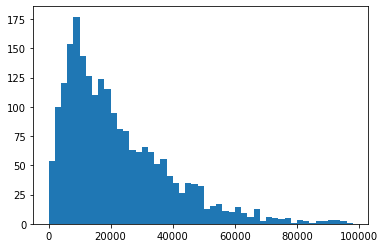

In [101]:
plt.hist(data['Revenue'], bins=range(0,100000,2000))

(array([3., 3., 2., 2., 2., 0., 4., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
        2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000,
        140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000,
        180000, 185000, 190000, 195000, 200000, 20

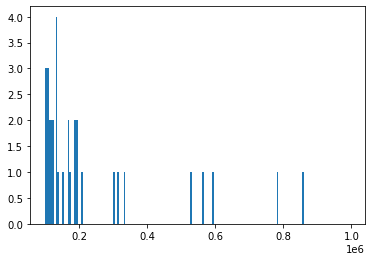

In [39]:
#Let's see the outliners
plt.hist(data['Revenue'], bins=range(100000,1000000,5000))

In [13]:
data['Visits'].describe()

count      2223.000000
mean      12871.529015
std        8188.285452
min         245.000000
25%        7774.000000
50%        9969.000000
75%       14886.000000
max      109148.000000
Name: Visits, dtype: float64

In [14]:
data['Visits'].max()

109148

(array([  1.,   9., 159., 449., 501., 309., 190.,  92.,  84.,  88.,  77.,
         48.,  55.,  28.,  25.,  31.,  10.,  10.,   7.,   9.,  15.,  11.,
          6.,   2.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.]),
 array([     0,   2000,   4000,   6000,   8000,  10000,  12000,  14000,
         16000,  18000,  20000,  22000,  24000,  26000,  28000,  30000,
         32000,  34000,  36000,  38000,  40000,  42000,  44000,  46000,
         48000,  50000,  52000,  54000,  56000,  58000,  60000,  62000,
         64000,  66000,  68000,  70000,  72000,  74000,  76000,  78000,
         80000,  82000,  84000,  86000,  88000,  90000,  92000,  94000,
         96000,  98000, 100000, 102000, 104000, 106000, 108000, 110000,
        112000, 114000, 116000, 118000]),
 <BarContainer object of 59 artists>)

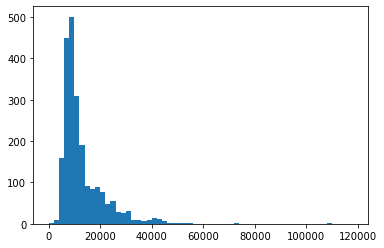

In [48]:
plt.hist(data['Visits'], bins=range(0,120000,2000))

In [49]:
#Let's see the correlation across the variables
data.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.044018,0.001226,0.659991,0.305776
Month,-0.044018,1.000000,0.009158,0.168876,0.128174
Day,0.001226,0.009158,1.000000,0.074226,0.088392
Visits,0.659991,0.168876,0.074226,1.000000,0.591148
Revenue,0.305776,0.128174,0.088392,0.591148,1.000000


In [103]:
#Now let's try to apply log to the variables, except when the value is 0 (inf.)
data_log = pd.DataFrame(np.log(data[data['Revenue'] != 0]))

In [104]:
#Now we can see a different correlation matrix. Visits still quite correlate with Revenue but Year as well
data_log.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.063566,0.001097,0.732171,0.604629
Month,-0.063566,1.000000,0.005938,0.092400,0.109626
Day,0.001097,0.005938,1.000000,0.054783,0.076481
Visits,0.732171,0.092400,0.054783,1.000000,0.675325
Revenue,0.604629,0.109626,0.076481,0.675325,1.000000


In [107]:
#Bear in mind that we are using Log e and therefore Pearson results are different
pearson_revenue = data_log['Revenue'].std() / data_log['Revenue'].mean()
pearson_traffic = data_log['Visits'].std() / data_log['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue} and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 0.09859521582003562 and Pearson Visits: 0.05443959700737877


In [108]:
data_log['Revenue'].describe()

count    2217.000000
mean        9.720446
std         0.958389
min         3.837730
25%         9.153696
50%         9.804346
75%        10.374114
max        13.662748
Name: Revenue, dtype: float64

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,   0.,   0.,   2.,
          1.,   0.,   2.,   4.,   2.,   2.,   5.,   6.,   8.,   8.,  12.,
         23.,  20.,  18.,  29.,  32.,  38.,  45.,  72.,  69.,  95., 104.,
        102., 100., 109., 133., 140., 132., 126., 111., 129., 128.,  99.,
        101.,  59.,  43.,  30.,  19.,  12.,   7.,   7.,   7.,   1.,   3.,
          5.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   3.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 2.        ,  2.13131313,  2.26262626,  2.39393939,  2.52525253,
         2.65656566,  2.78787879,  2.91919192,  3.05050505,  3.18181818,
         3.31313131,  3.44444444,  3.57575758,  3.70707071,  3.83838384,
         3.96969697,  4.1010101 ,  4.23232323,  4.36363636,  4.49494949,
         4.62626263,  4.75757576,  4.888

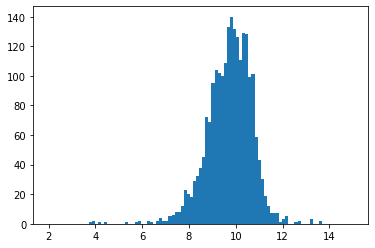

In [109]:
plt.hist(data_log['Revenue'], bins=np.linspace(start=2,stop=15,num=100))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   3.,   2.,   3.,   6.,   6.,  12.,  17.,  32.,  36.,  33.,
         31.,  38.,  55.,  75., 101., 126., 105., 106.,  97., 120., 128.,
         95.,  95.,  77.,  60.,  62.,  74.,  40.,  34.,  32.,  32.,  38.,
         41.,  46.,  39.,  42.,  33.,  27.,  35.,  26.,  22.,  17.,  25.,
         17.,   8.,   7.,   9.,   9.,  11.,  13.,  10.,   2.,   1.,   2.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 7.        ,  7.05050505,  7.1010101 ,  7.15151515,  7.2020202 ,
         7.25252525,  7.3030303 ,  7.35353535,  7.4040404 ,  7.45454545,
         7.50505051,  7.55555556,  7.60606061,  7.65656566,  7.70707071,
         7.75757576,  7.80808081,  7.85858586,  7.90909091,  7.95959596,
         8.01010101,  8.06060606,  8.111

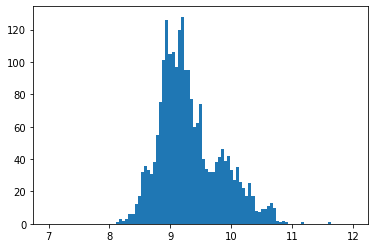

In [110]:
plt.hist(data_log['Visits'], bins=np.linspace(start=7,stop=12,num=100))

In [137]:
#This is a new DataFrame 
data_by_year_month = data.groupby(['Year','Month'])[['Visits','Revenue']].sum()
data_by_year_month = data_by_year_month.reset_index()

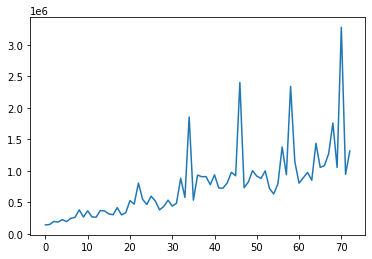

In [20]:
plt.plot(data.groupby(['Year','Month'])[['Revenue']].sum().reset_index().index,data.groupby(['Year','Month'])[['Revenue']].sum())

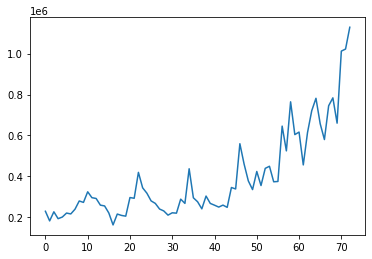

In [74]:
plt.plot(data.groupby(['Year','Month'])[['Visits']].sum().reset_index().index,data.groupby(['Year','Month'])[['Visits']].sum())

In [225]:
def back_poly_parameters(l,i,x):
    """
    DESCRIPTION
      This function return a vector of coefficients for plotting easily. It is using backtracking
    ARGUMENTS
      l: list of coefficients from np.polyfit, it does not matter the degree
      i: This is the len of the list
      x: It is the X parameter
    RETURN
      A value p[0] * x**deg + ... + p[deg]
    """
    if i == 0:
        return 0
    else:
        return l[-i]*x**(i-1) + back(i-1,l,x)

In [226]:
x = data_by_year_month.index
#Lets prepare a polynomial regression line for Revenue
y_revenue = data_by_year_month['Revenue']
d_r = 2 #This is the degree for the polynomial
list_revenue = np.polyfit(x, y_revenue, d_r)

#Lets prepare a polynomial regression line for Revenue
y_visits = data_by_year_month['Visits']
d_v = 2 #This is the degree for the polynomial
list_visits = np.polyfit(x, y_visits, d_v)

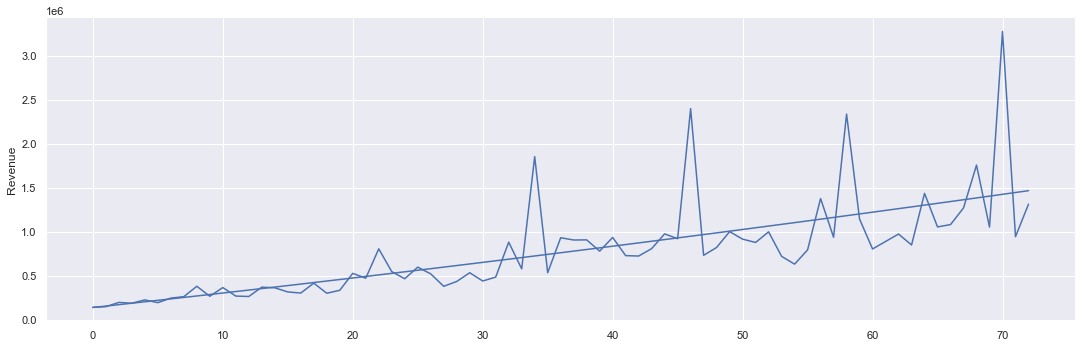

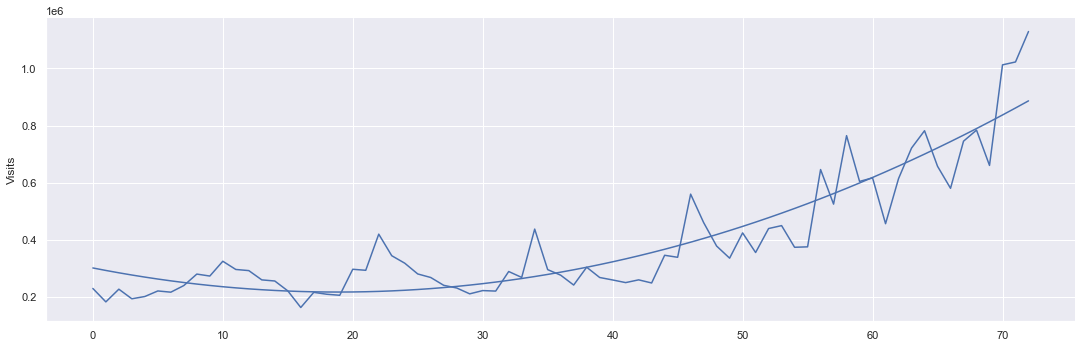

In [227]:
#Here we can see the trend across the months in Revenue and Visits and we draw another line.
#Actually that line is a polynomial line, in the Revenue case, it is a pure line because degree=2 does not
#Show any difference. However, the Visits chart is adjusting much better with a degree=2 or even 3
sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Revenue', kind='line', aspect=3)
plt.plot(x, back_poly_parameters(list_revenue, len(list_revenue), x))
#plt.axvline(100, color="r", linestyle="--");
sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Visits', kind='line', aspect=3)
plt.plot(x, back_poly_parameters(list_visits, len(list_visits), x))

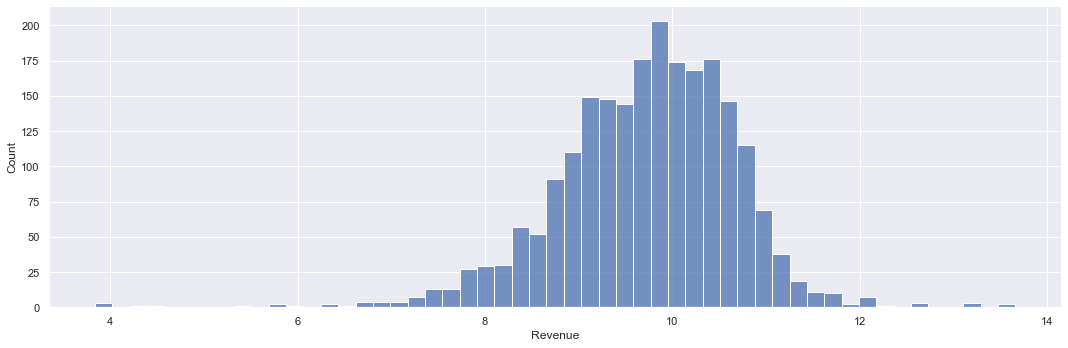

In [229]:
sns.displot(data=data_log, x='Revenue', aspect=3)

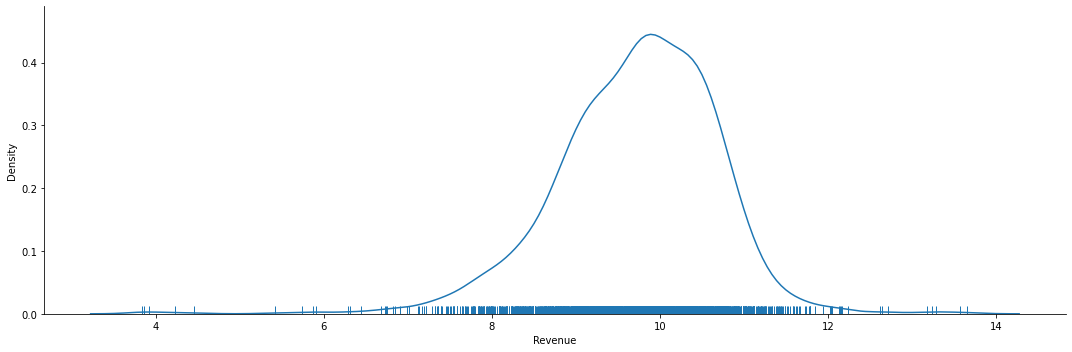

In [24]:
sns.displot(data=aux, x='Revenue', kind='kde', aspect=3, rug=True)

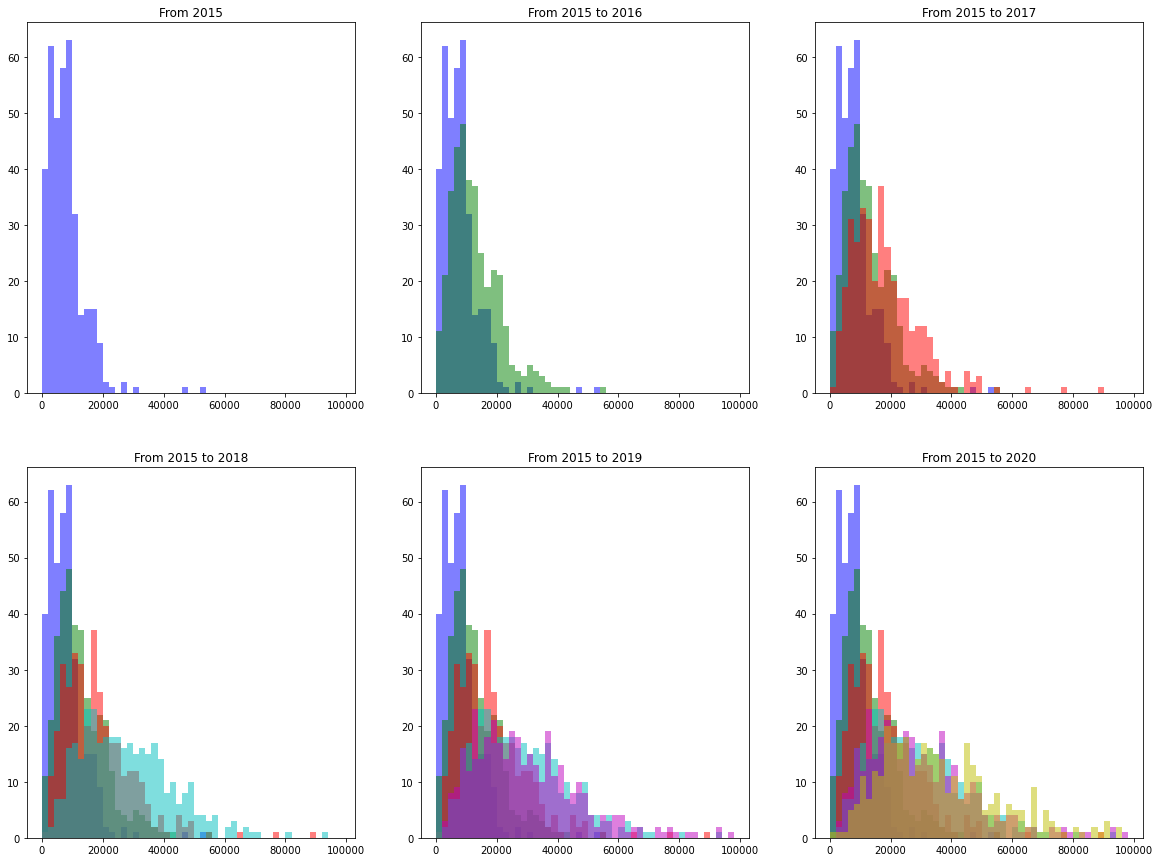

In [25]:
#It seems the Revenue distribution follows a Gamma Distribution even when yo
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,100000,2000), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Revenue', 'Year', data['Year'].unique(), ax)


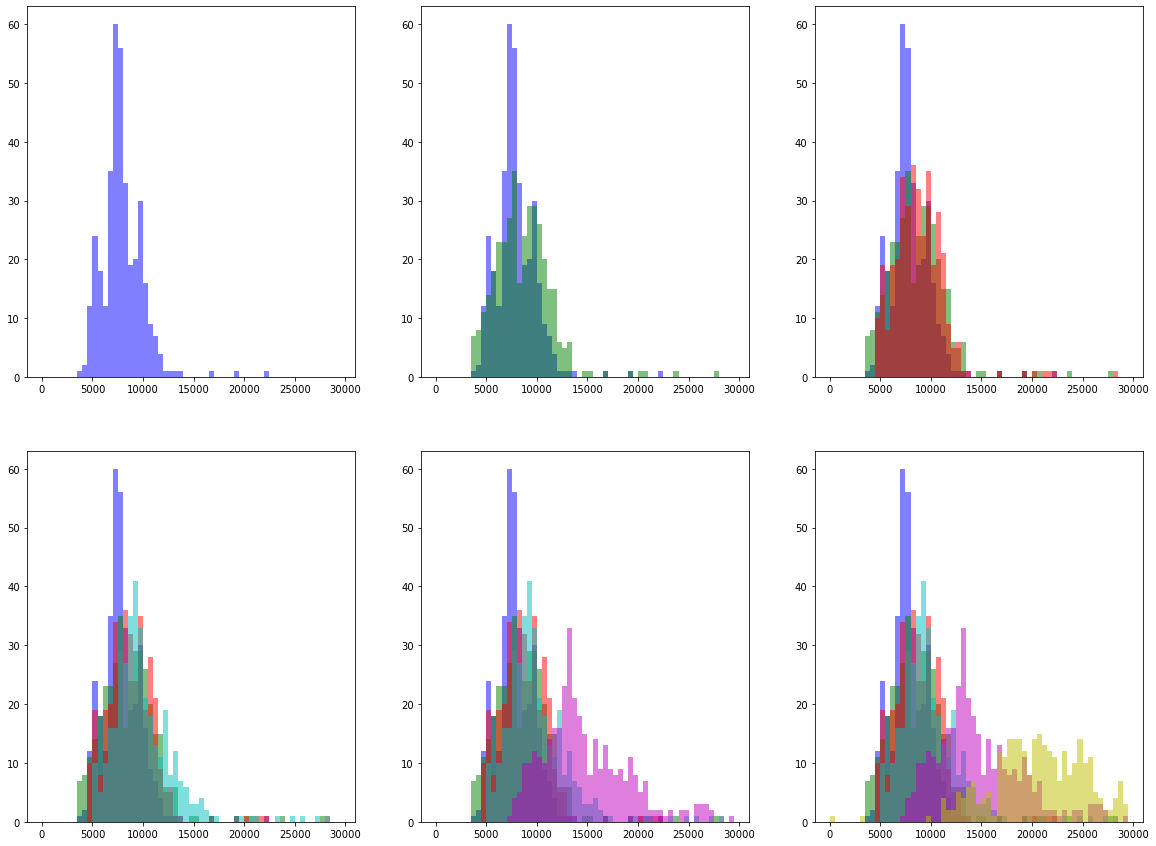

In [26]:
#Traffic seems a Norm Distribution but when you add more years it seems a Gamma Distribution but every year
#Seems centrated. Further analysis are needed
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,30000,500), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            k = 0
            m += 1
            
draw_hist(data, 'Visits', 'Year', data['Year'].unique(), ax)

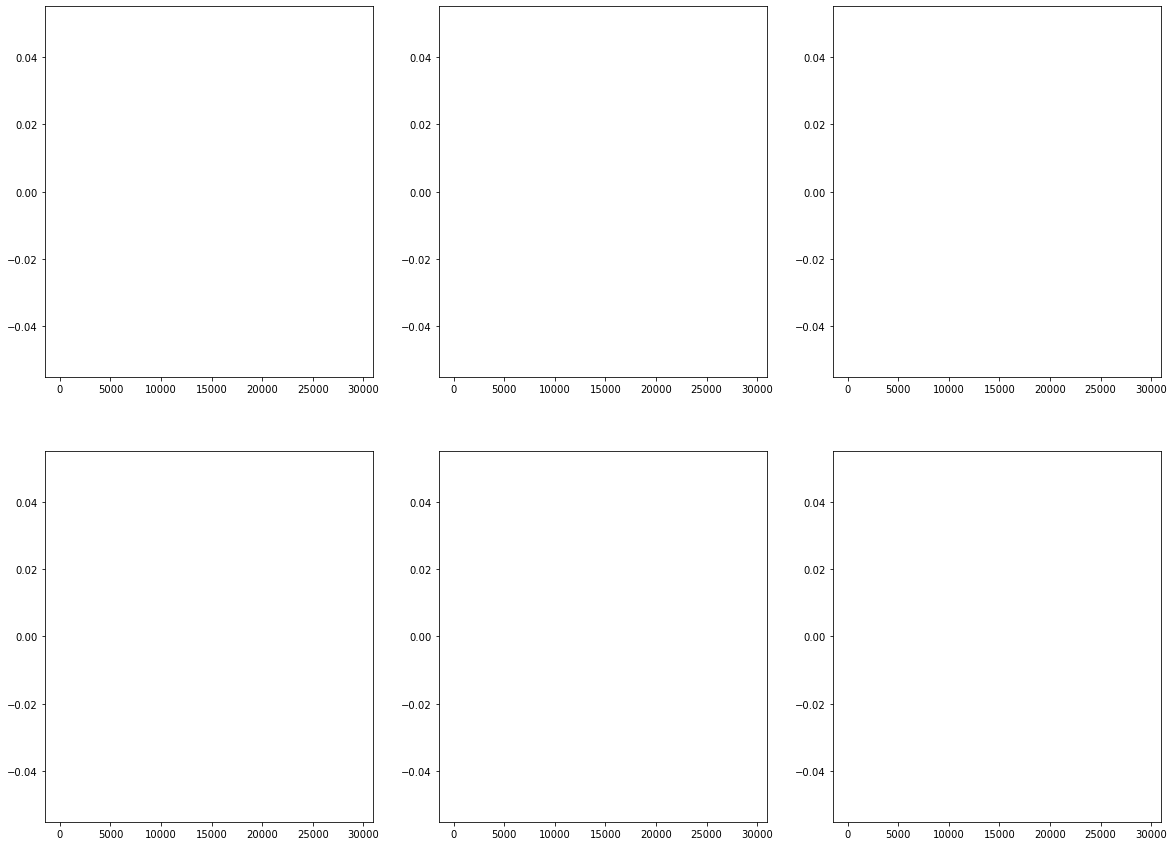

In [27]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
draw_hist(data, 'Visits', 'Year', data['Visits'].unique(), ax)

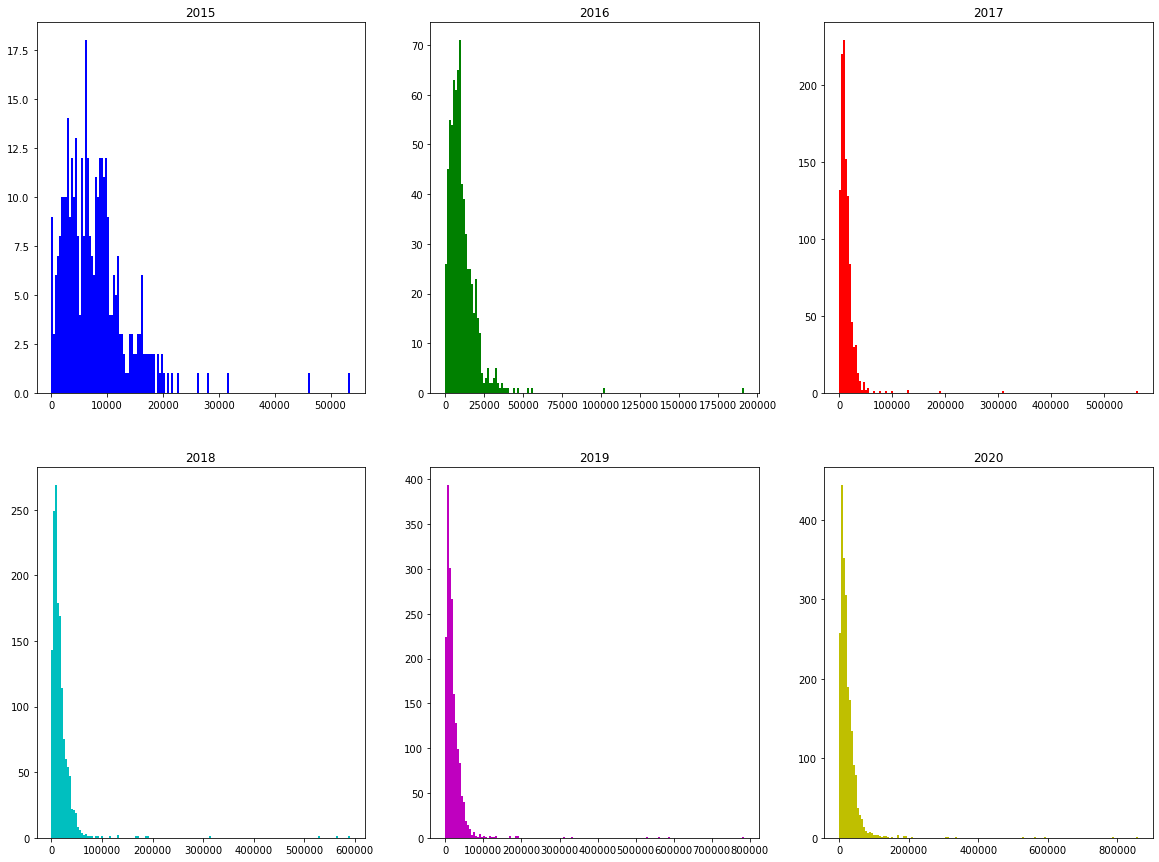

In [28]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i,j].hist(df[df[col_con] <= lista[k]][col], bins=150, color=colors[k], histtype='stepfilled')
            ax[i,j].set(title=lista[k])
            k += 1

draw_hist(data, 'Revenue', 'Year', data['Year'].unique(), ax) 

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Visits', ylabel='Density'>

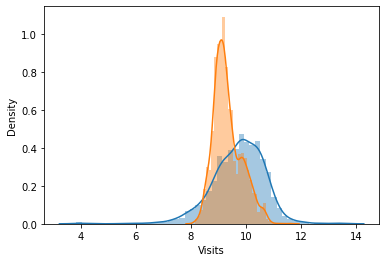

In [29]:
sns.distplot(aux['Revenue'])
sns.distplot(aux['Visits'])

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Visits', ylabel='Density'>

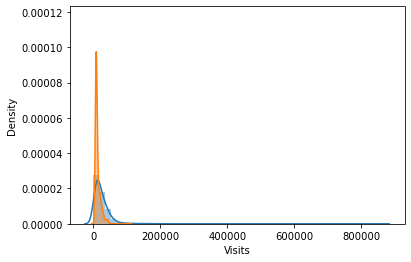

In [30]:
sns.distplot(data['Revenue'], label='Revenue')
sns.distplot(data['Visits'], label='Visits')

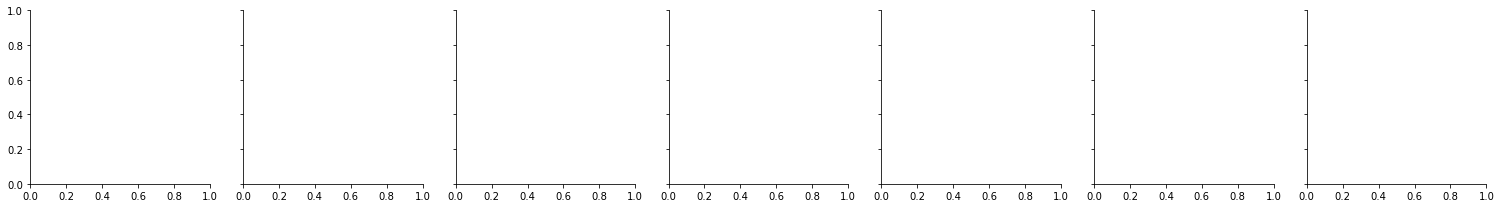

In [31]:
g = sns.FacetGrid(data, col='Year', aspect=1)

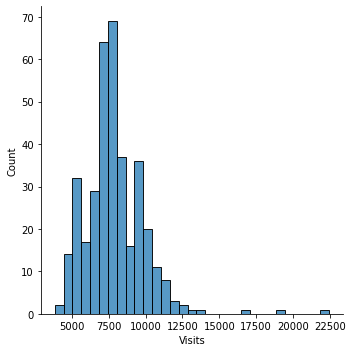

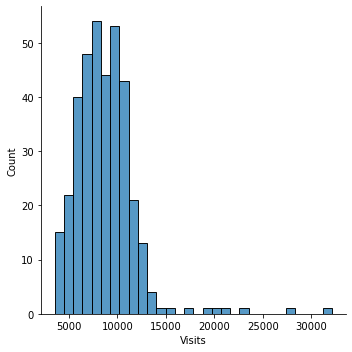

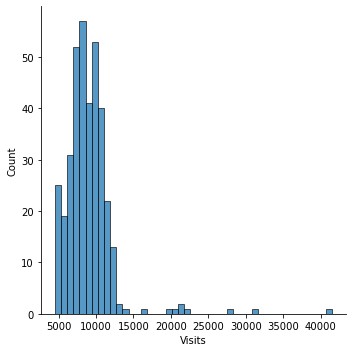

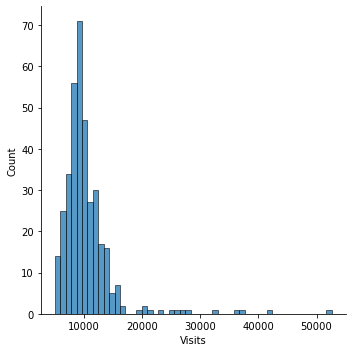

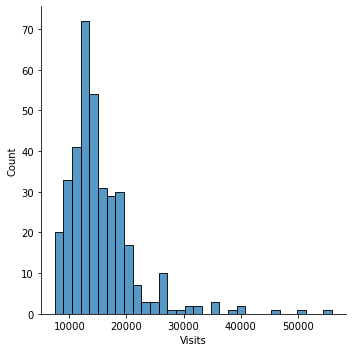

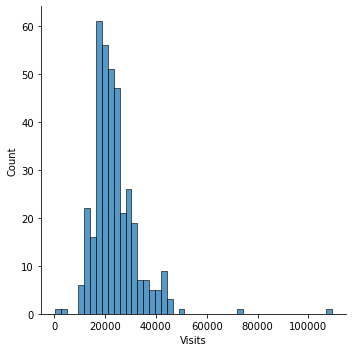

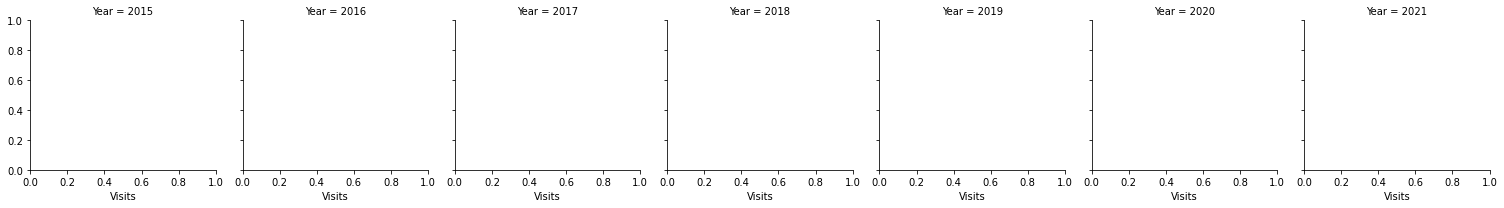

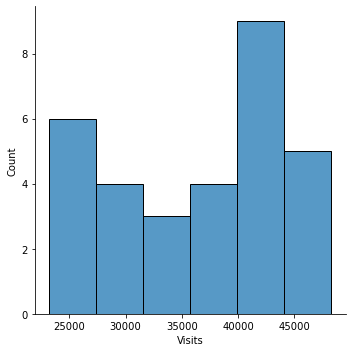

In [32]:
g = g.map(sns.displot, 'Visits');

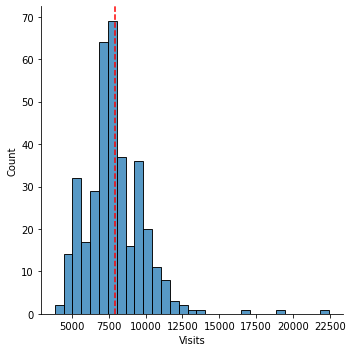

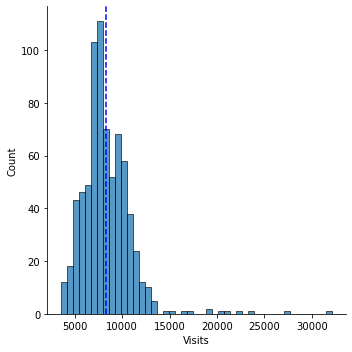

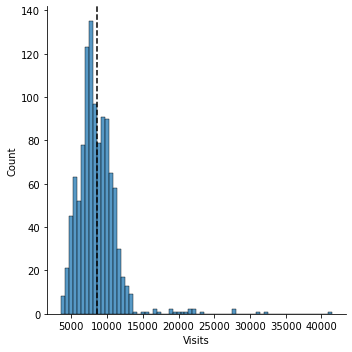

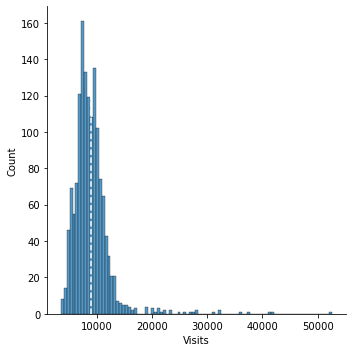

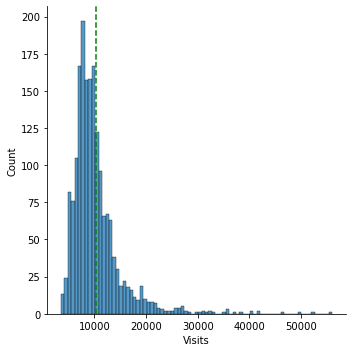

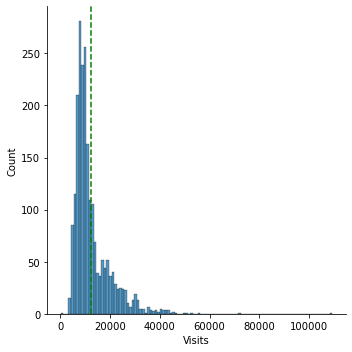

In [33]:
sns.displot(data[data['Year'] == 2015]['Visits'], label='Visits')
plt.axvline(data[data['Year'] == 2015]['Visits'].mean(), color="r", linestyle="--");
sns.displot(data[data['Year'] <= 2016]['Visits'], label='Visits')
plt.axvline(data[data['Year'] <= 2016]['Visits'].mean(), color="b", linestyle="--");
sns.displot(data[data['Year'] <= 2017]['Visits'], label='Visits')
plt.axvline(data[data['Year'] <= 2017]['Visits'].mean(), color="k", linestyle="--");
sns.displot(data[data['Year'] <= 2018]['Visits'], label='Visits')
plt.axvline(data[data['Year'] <= 2018]['Visits'].mean(), color="w", linestyle="--");
sns.displot(data[data['Year'] <= 2019]['Visits'], label='Visits')
plt.axvline(data[data['Year'] <= 2019]['Visits'].mean(), color="g", linestyle="--");
sns.displot(data[data['Year'] <= 2020]['Visits'], label='Visits')
plt.axvline(data[data['Year'] <= 2020]['Visits'].mean(), color="g", linestyle="--");